In [1]:
from gp_sinkhorn.SDE_solver import solve_sde_RK
from gp_sinkhorn.utils import plot_trajectories_2
from gp_sinkhorn.MLE_drift import *
from gp_sinkhorn import MLE_drift

import copy
import torch
import math
import numpy as np

from pyro.contrib.gp.kernels import Exponential, Matern32, RBF, Brownian, Combination, Product, Sum

from celluloid import Camera
from IPython.display import HTML
import matplotlib.pyplot as plt

# Generating OU Based data

Here we simmulate some OU data using the EM SDE Solver . We will use this data to fit forwards and backwards drifts.

In [2]:
theta = 7.0
sigma = 1
dt = 0.01
N = int(math.ceil(1.0/dt))
b_drift = lambda x: -theta * x[...,:-1] 

In [3]:
num_samples = 10
dim = 1
mu, std = 5, 0.01
X_0 = torch.distributions.normal.Normal(loc=mu, scale=std).sample((num_samples, dim)) #.reshape(num_samples, dim,-1)

In [4]:
t, Xts = solve_sde_RK(b_drift=b_drift,sigma=sigma, X0=X_0, dt=dt, N=N)

(<Figure size 1080x720 with 1 Axes>, <AxesSubplot:ylabel='$x(t)$'>)

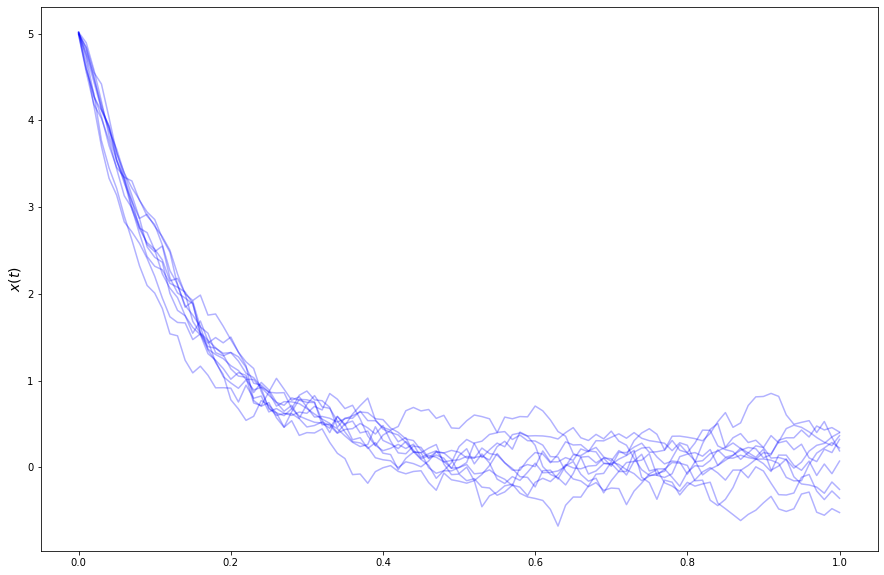

In [5]:
plot_trajectories_2(Xts, t, remove_time=True)

# Fitting Forward Drift with GP
In this section we demonstrate how to fit the forwards drift of an OU process using the GP drift fraemwork. Theres a small problem using Pyro I dont know why it doesnt let me flatten Ys , does it not support multioutput formats for GPs ?

0.0001


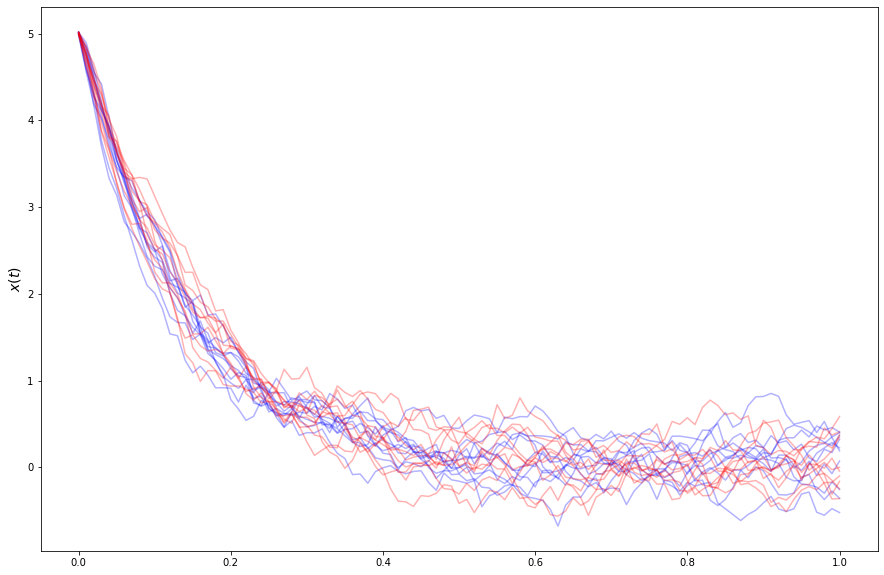

In [6]:
from functools import partial
# kern = partial(RBF, variance=torch.tensor(0.00000001), lengthscale=torch.tensor(0.05))
# kern = partial(RBF, variance=torch.tensor(dt**2), lengthscale=torch.tensor(1))
from importlib import reload

# def kern_(input_dim, variance=None):
#     return RBF(input_dim=input_dim, variance=torch.tensor(dt**2), lengthscale=torch.tensor(1))
def kern_(input_dim, variance=None):
    return RBF(input_dim=input_dim, variance=1.0/torch.tensor(dt)**2, lengthscale=torch.tensor(1))
# inpu
print(dt**2)
# print(kern.variance)
# reload(MLE_drift)
# gp_ou_drift = fit_drift(Xts,N,dt,noise=sigma, kernel=kern)
gp_ou_drift_ = fit_drift(Xts,N,dt,noise=sigma, kernel=kern_)


t_hat, Xts_hat = solve_sde_RK(b_drift=gp_ou_drift_,sigma=sigma**2, X0=X_0, dt=dt, N=N) # Solver using GP predicted drift
fig_axs = plot_trajectories_2(Xts, t, remove_time=True, show=False)
plot_trajectories_2(Xts_hat, t_hat, remove_time=True, fig_axs=fig_axs, color='r');

# Fitting Backwards Drift with GP

In this section we reverse the time series before passing it to the GP. Then we inspect that if starting from the empirical hitting distribution of the OU process namely $X_1$ , where does our GP drift take us to, if correct it should take us back to $X_0$ .

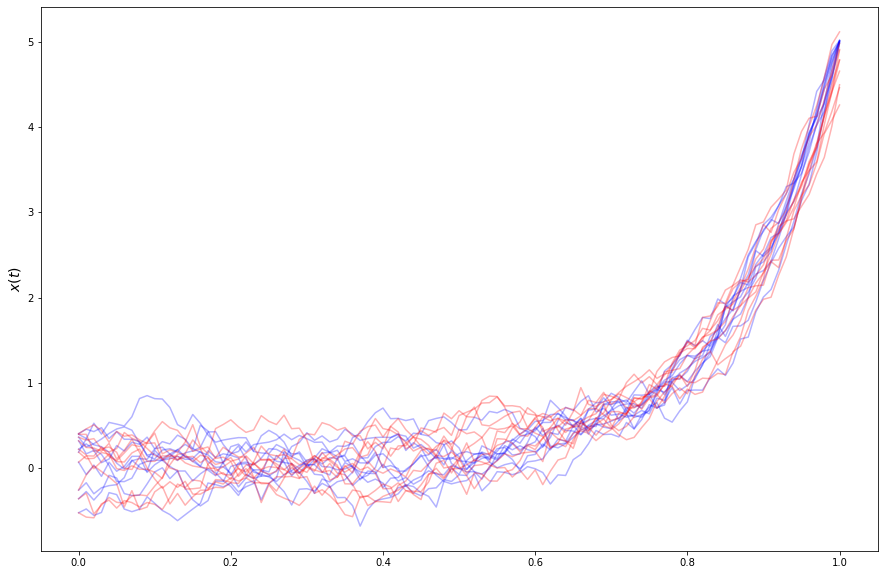

In [7]:

Xbts = copy.deepcopy(Xts)
Xbts[:,:,0] = Xbts[:,:,0].flip(1) # Reverse the series


# kern = partial(Exponential, lengthscale=torch.tensor(0.01))
# kern = partial(RBF, variance=torch.tensor(dt**2), lengthscale=torch.tensor(1))
# kern = partial(RBF, variance=torch.tensor(1), lengthscale=torch.tensor(1))


gp_ou_drift = fit_drift(Xbts,N,dt, noise=sigma**2, kernel=kern_)
tb_hat, Xbts_hat = solve_sde_RK(b_drift=gp_ou_drift,sigma=sigma, X0=Xbts[:,0,0].reshape((-1,1)), dt=dt, N=N) # Solver using GP predicted drift

fig_axs = plot_trajectories_2(Xbts, t, remove_time=True, show=False)
plot_trajectories_2(Xbts_hat, tb_hat, remove_time=True, fig_axs=fig_axs, color='r');

#  IPFP

In [23]:
theta = 7.0
sigma = 1
dt = 0.01
N = int(math.ceil(1.0/dt))
b_drift = lambda x: -theta * x[...,:-1] 

num_samples = 30
X_0 = torch.distributions.normal.Normal(loc=0, scale=0.5).sample((num_samples, 1)) #.reshape(num_samples, dim,-1)

X_1_a = torch.distributions.normal.Normal(loc=1.8, scale=0.6**2).sample((num_samples//2, 1)) 
X_1_b = torch.distributions.normal.Normal(loc=-1.9, scale=0.6**2).sample((num_samples//2, 1))
X_1 = torch.cat((X_1_a,X_1_b))

In [24]:
prior_X_0=torch.cat((X_1,X_0))
prior_X_0.shape

torch.Size([60, 1])

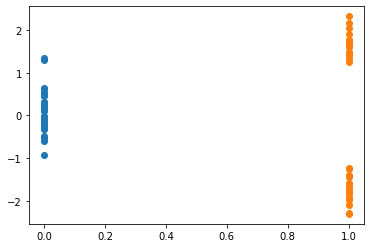

In [25]:
plt.scatter([0]*X_0.shape[0],X_0)
plt.scatter([1]*X_0.shape[0],X_1)

In [26]:
result = MLE_IPFP(X_0,X_1,prior_X_0=prior_X_0, sparse=False, num_data_points=25, num_time_points=9, N=N)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.77s/it]


(<Figure size 1080x720 with 1 Axes>, <AxesSubplot:ylabel='$x(t)$'>)

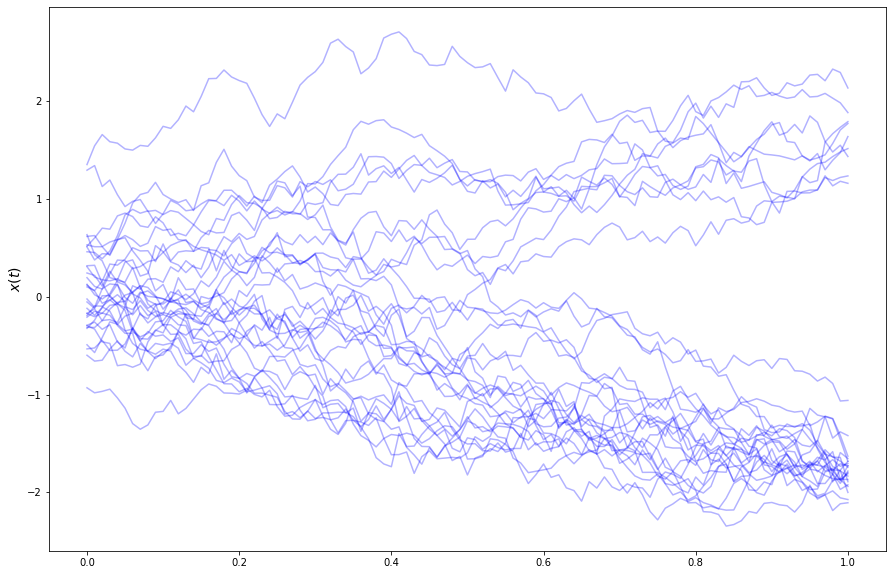

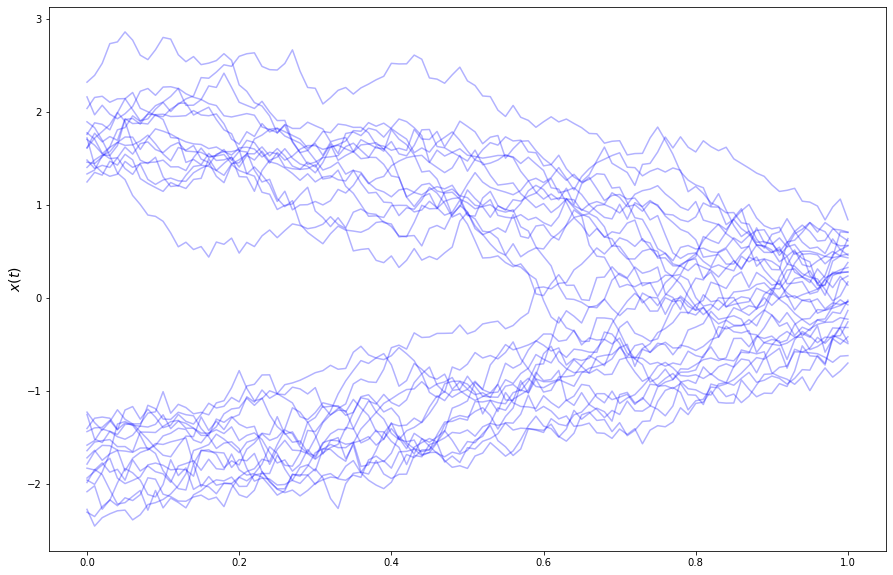

In [27]:
T,M,T2,M2 = result[-1]
plot_trajectories_2(M,T)
plot_trajectories_2(M2,  T2)

# 2D example

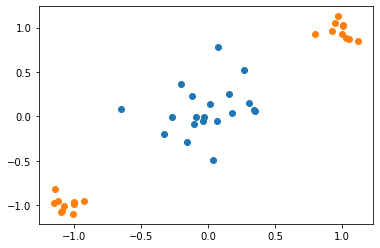

In [32]:
num_samples = 10
N = 100
X_0 = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2),torch.eye(2)*0.05).sample((num_samples*2,1)).reshape((-1,2))

X_1_a = torch.distributions.multivariate_normal.MultivariateNormal(torch.ones(2),torch.eye(2)*0.01).sample((num_samples,1)).reshape((-1,2))
X_1_b = torch.distributions.multivariate_normal.MultivariateNormal(torch.ones(2)*-1,torch.eye(2)*0.01).sample((num_samples,1)).reshape((-1,2))
X_1 = torch.cat((X_1_a,X_1_b))

# TO reshape
plt.scatter(X_0[:,0],X_0[:,1])
plt.scatter(X_1[:,0],X_1[:,1])


In [33]:
result = MLE_IPFP(X_0,X_1,N=N,sigma=0.3, iteration=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:20<00:00,  1.34s/it]


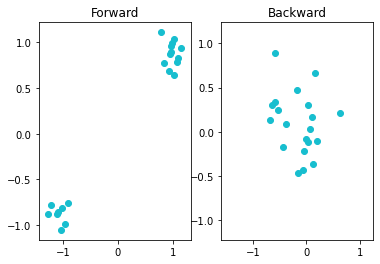

In [35]:
fig, (ax1, ax2) =  plt.subplots(1, 2)
camera = Camera(fig)
M = result[-1][1]
M2 = result[-1][3]
for i in range(N):    
    ax1.scatter(M[:,i,0].detach(),M[:,i,1].detach())
    ax2.scatter(M2[:,i,0].detach(),M2[:,i,1].detach())
    ax1.set_title("Forward")
    ax2.set_title("Backward")
    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')
